0.0032578678174494356 0.024931882238699066


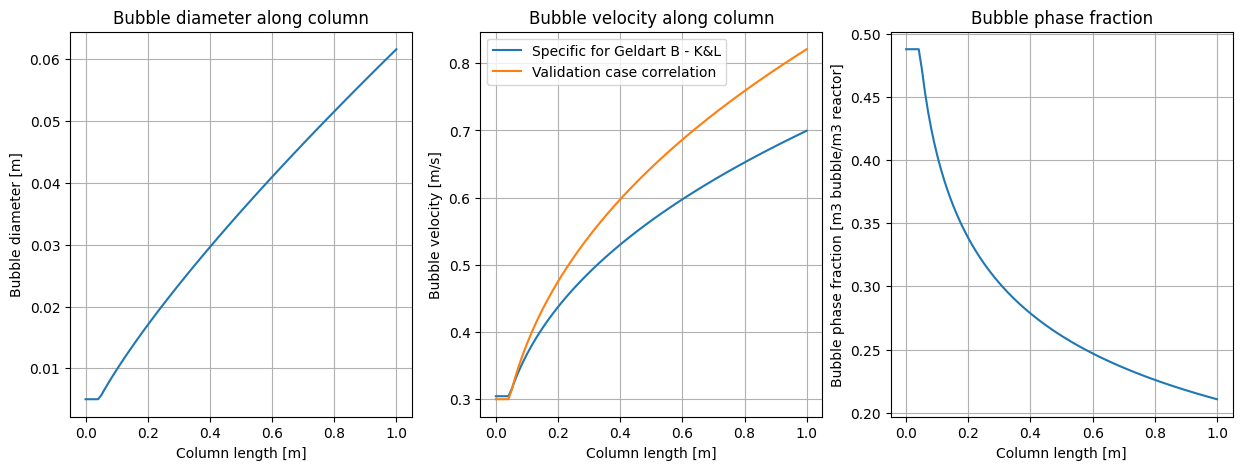

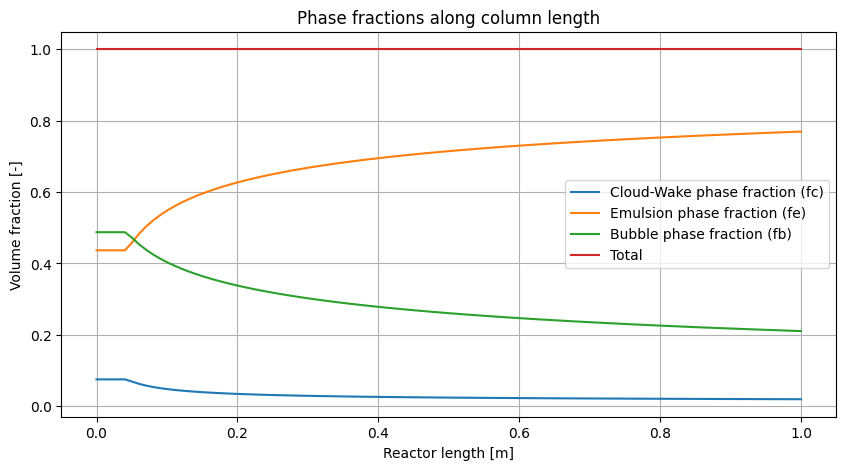

In [1]:
import numpy as np
import pymrm as mrm
import matplotlib.pyplot as plt
import scipy.sparse as sps

from FluidizationHydrodynamics import *

# Fluidized bed model for Direct Air Capture
d_p = 116e-6 # 300-1250 micrometers range for Lewatit VP OC 1065 -> Lower than 300 micrometers is Geldart A
u_0 = 0.15 # This should be obtained from the capacities of ClimeWorks
nz = 100

model = FluidizationHydrodynamics()
model.init(d_p, u_0, nz)
print(model.u_mf, model.Re_mf)
fig, ax = plt.subplots(1,3,figsize = (15,5))
ax[0].plot(model.z, model.d_b)
ax[1].plot(model.z,model.u_b, label =  'Specific for Geldart B - K&L')
ax[1].plot(model.z,model.u_b_1, label = 'Validation case correlation')
ax[1].legend()
ax[0].grid()
ax[1].grid()

ax[0].set_xlabel('Column length [m]')
ax[0].set_ylabel('Bubble diameter [m]')

ax[1].set_xlabel('Column length [m]')
ax[1].set_ylabel('Bubble velocity [m/s]')

ax[0].set_title('Bubble diameter along column')
ax[1].set_title('Bubble velocity along column')

ax[2].plot(model.z, model.fb)
ax[2].set_title('Bubble phase fraction')
ax[2].set_xlabel('Column length [m]')
ax[2].set_ylabel('Bubble phase fraction [m3 bubble/m3 reactor]')
ax[2].grid()

z = model.z
fc= model.fc
fb = model.fb
fw = model.fw
delta = model.fb
fe = model.femulsion

umf = model.u_mf
ub = model.u_b
ub_second_option = model.u_b_1
ue = model.u_emulsion
kgs = model.kgs
kbc_ce = model.kgas
db = model.d_b

plt.figure(figsize=(10, 5))
plt.plot(z,model.epsilon_cloud_wake ,label = 'Cloud-Wake phase fraction (fc)')
# plt.plot(z,model.epsilon_wake,label = 'Wake phase fraction (fw)')
plt.plot(z,fe*delta,label = 'Emulsion phase fraction (fe)')
plt.plot(z,delta,label = 'Bubble phase fraction (fb)')
plt.plot(z, delta + fe*delta + fw*delta + fc*delta , label = 'Total')
plt.title('Phase fractions along column length')
plt.xlabel('Reactor length [m]')
plt.ylabel('Volume fraction [-]')
plt.legend()
plt.grid()

## Plot of mass transfer coefficients
# plt.figure(figsize = (10,5))
# # plt.plot(z,kbc_ce[0,:,1])
# plt.plot(z,kbc_ce[2,:,1])
# print(umf)

Weitz-Pater criterion for CO2: 130.1305607275179
Weitz-Pater criterion for N2: 130.13056072754387


(6655.554505502622, 292341.6962349645)

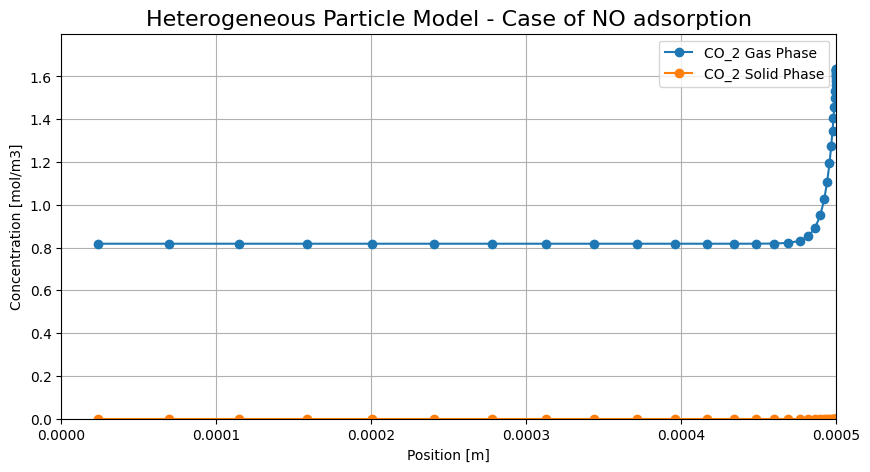

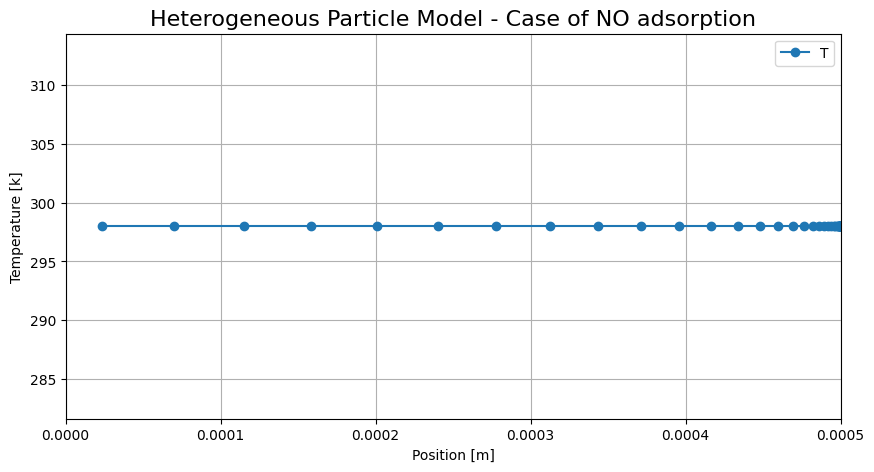

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.sparse as sps 
import pymrm  as mrm
import math

# ADD LEWATIT PROPERTIES
# CHECK IF EFFECTIVE DIFFUSIVITIES ARE CONSIDERED
# ADSORPTION KINETICS

# Heterogeneous particle model for adsorption
class AdsorptionParticleModel:
    def __init__(self, Tin, dp):
        self.Tin = Tin
        self.P = 1*101325 

        ## Gas constants
        self.Rho_g = 1  #Density of the gas
        self.eta_g = 4e-5 #Viscosity gas 
        self.Cp_g = 5e3 #Heat capacity gas
        self.lam_g = 0.03 #Thermal diffusivity
        self.Rg = 8.314  #Gas constant

         # For the Lewatit VP OC 1065 adsorbent particle
        self.lam_s = 70 # Thermal diffusivity NEEDED
        self.rho_s = 744 # Solid density
        self.d_p = dp # Diameter of the particle 
        self.Cp_s = ((-3.23e4)/(self.Tin**2) + (0.00227)*(self.Tin) - (-0.994))*(10**3) # Heat capacity 
        self.Dax_s = 0.0
        self.eps_b = 0.4 # Packing in the bed at minimum fluidization -> should be epsilon_mf from FluidizationHydrodynamics
        self.eps_s = 0.338 # Porosity of the Lewatit particle
        self.tauw = np.sqrt(2)

        # Check how to define the heat transfer coefficient. Also, the use of epsilon values.
        self.lam_g = 0.03 # Thermal conductivity of air [W/m/K]
        self.R_gas = 8.314 # Gas constant [J/mol/K]
        self.lam_s = 73 # Thermal conductivity of Lewatit [W/m/K] REQUIRED FOR PARTICLE MODEL
        self.A = self.lam_s/self.lam_g 
        self.B = 1.25*((1-self.eps_b)/self.eps_b)**(10/9)
        self.gamma = 2/(1-self.B/self.A)*((self.A-1)/(1-self.B/self.A)**2*self.B/self.A*(np.log(self.A/self.B))-0.5*(self.B+1))

        #  Check how the static thermal diffusion is considered
        self.lam_stat = self.lam_g*((1-np.sqrt(1-self.eps_b))+np.sqrt(1-self.eps_b)*self.gamma)
        
        self.Df_Thermal = self.lam_g/(self.Rho_g*self.Cp_g) # Thermal diffusivity of air [m2/s]
        self.Ds_Thermal = self.lam_s/(self.rho_s*self.Cp_s) # Thermal diffusivity of the particle [m2/s]

        #Heat of reaction
        self.H_r = -81e3 #Heat ofadsorption in J/mol  
        
        #Simulation parameters
        self.Nr = 40
        self.Nc = 10 # 4 components and 1 temperatures for each solid and gas phase
        self.Tin = 298
        self.lam_s = 70 

        self.R = dp/2  # Radius of the particle
        self.dp = 2*self.R
        self.dt = 0.01 #np.inf  # Time step (infinity for steady state)
        self.dr_large = 0.1 * self.R  # Initial large grid spacing
        self.refinement_factor = 0.75  # Factor for refining the grid

        self.r_f = mrm.non_uniform_grid(0, self.R, self.Nr + 1, self.dr_large, self.refinement_factor)
        self.r_c = 0.5 * (self.r_f[:-1] + self.r_f[1:])

        self.P = 1*101325 
        self.X_CO2 = 0.04 #The actual figure is 0.0004
        self.X_O2 = 0.2095
        self.X_Ar = 0.0093 
        self.X_N2 = 1 - self.X_CO2 - self.X_O2 #- self.X_Ar
        self.Cin_N2 = self.P*self.X_N2/(self.Rg*self.Tin)
        self.Cin_CO2 = self.P*self.X_CO2/(self.Rg*self.Tin)

        ## Maxwell-Stefan constants
        #Molecular weights 
        self.M_CO2 = 44  # 1 
        self.M_N2 = 2    # 2
        self.M_O2 = 32  # 3
        self.M_Ar = 39.95  # 4

        #Diffusion volumes
        self.V_CO2 = 26.7 
        self.V_N2 = 6.12
        self.V_O2 = 16.3 
        self.V_Ar = 16.2

        self.Dm_CO2, self.Dm_N2, self.Dm_O2, self.Dm_Ar = self.calculate_average_diffusion_coefficients(self.Tin, self.P)
        
        self.c0 = np.array([0,0,0,0, self.Tin,0,0,0,0, self.Tin], dtype='float')
        self.cin = np.array([self.Cin_CO2, self.Cin_N2, 0, 0,  self.Tin,0, 0, 0, 0,  self.Tin], dtype='float')
    
        # Change to a mixed boundary condition the file is in the Analytical solution
        self.bc = {'a':[1,0],'b':[0,1], 'd':[0.0, [self.cin]]}

        self.init_field(self.c0)

        self.init_Jac()

        self.freq_out=100

    def fuller(self, T, M1, M2, V1, V2, P):
        D_ij = 1.013e-2 * T**1.75 / P * np.sqrt(1/M1 + 1/M2) / (V1**(1/3) + V2**(1/3))**2
        return D_ij

    def calculate_average_diffusion_coefficients(self, T, P):
        # Define the molecules and their properties
        molecules = [
            ('CO2', self.M_CO2, self.V_CO2),
            ('N2', self.M_N2, self.V_N2),
            ('O2', self.M_O2, self.V_O2),
            ('Ar', self.M_Ar, self.V_Ar)
        ]
        
        # Calculate diffusion coefficients for each molecule with every other molecule
        diffusion_coeffs = {mol[0]: [] for mol in molecules}
        
        for i, (name1, M1, V1) in enumerate(molecules):
            for j, (name2, M2, V2) in enumerate(molecules):
                if i != j:
                    diffusion_coeff = self.fuller(T, M1, M2, V1, V2, P)*self.eps_s/self.tauw
                    diffusion_coeffs[name1].append(diffusion_coeff)
        
        # Calculate average diffusion coefficient for each molecule
        avg_diffusion_coeffs = {name: np.mean(coeffs) for name, coeffs in diffusion_coeffs.items()}
        #print(f"Average Diffusion Coefficients: {avg_diffusion_coeffs}")
        
        return avg_diffusion_coeffs['CO2'], avg_diffusion_coeffs['N2'], avg_diffusion_coeffs['O2'], avg_diffusion_coeffs['Ar']


    def init_field(self, c0):
        self.c = np.full([self.Nr, self.Nc], c0, dtype='float')

    ## Reaction rate equations
    def reaction(self, c):
        T_p_gas = c[:,4]
        T_p_solid = c[:,9]


        # CO2 and N2 are the 2 adsorbed species
        pCO2 = c[:,0]*self.Rg*T_p_gas
        pN2 = c[:,1]*self.Rg*T_p_gas
        pO2 = c[:,2]*self.Rg*T_p_gas
        pAr = c[:,3]*self.Rg*T_p_gas
 
        # How is the intra particle mass and heat transfer between the different phases obtained? 
        Sh = 2
        Nu = 2

        #  Check if these are defined correctly? Also if the effective values should be considered
        kCO2 = Sh*self.Dm_CO2/self.d_p
        kN2 = Sh*self.Dm_N2/self.d_p


        # Use the specific surface areas of the Lewatit
        BETarea = 31*self.rho_s*1000 # (m2/g of catalyst)(kg/m3 catalyst)
        mtCO2 = kCO2*(BETarea)*(self.eps_s)*(c[:,5] - c[:,0])
        # mtCO2 = (c[:,0] - c[:,5])
        mtN2 = kN2*(BETarea)*(self.eps_s)*(c[:,6] - c[:,1])


        kheat = Nu*self.d_p/self.Df_Thermal
        # CHECK THE SIGNS AND THE UNITS OF THIS
        ht = kheat*(6/self.d_p)*(self.eps_s)*(c[:,4] - c[:,9])

        f = np.zeros_like(c)
        
        # r = k*(Pco2-(Pco*Ph2o)/(Ke*Ph2))/(1+K_H2O*Ph2o/Ph2)*self.rho_s*1e3/101325

        # r[np.isnan(r)]=0
        r = 0

        f[:,0] = mtCO2
        f[:,1] = mtN2
        f[:,2] = 0    
        f[:,3] = 0
        f[:,4] = 0 #ht # -self.H_r*r/self.rho_s/self.Rho_g
 
        f[:,5] = -mtCO2
        f[:,6] = -mtN2
        f[:,7] = 0
        f[:,8] = 0
        f[:,9] = 0 #-self.H_r*r - ht# -self.H_r*r/self.rho_s/self.Rho_g

        return f 

    def init_Jac(self):
        self.Jac_accum= 1/self.dt*sps.eye_array(self.Nr*self.Nc)
        self.Grad, grad_bc = mrm.construct_grad(self.c.shape, self.r_f, self.r_c, self.bc, axis=0)
        self.Div = mrm.construct_div(self.c.shape, self.r_f, nu=2, axis =0)
        Dax_m = mrm.construct_coefficient_matrix([[self.Dm_CO2, self.Dm_N2, self.Dm_O2, self.Dm_Ar, self.Df_Thermal]], self.c.shape, axis=0)
        #Dax_m = mrm.construct_coefficient_matrix([[self.Dm_CO2, self.Dm_N2, self.Dm_O2, self.Dm_Ar, self.Df_Thermal,self.Dm_CO2, self.Dm_N2, self.Dm_O2, self.Dm_Ar, self.Ds_Thermal]], self.c.shape, axis=0)
        self.Flux = -Dax_m@self.Grad
        self.flux_bc = -Dax_m@grad_bc
        self.g_const = self.Div@self.flux_bc
        self.Jac_const = self.Jac_accum + self.Div@self.Flux

    def lin_pde(self, c, c_old):
        f_react, Jac_react = mrm.numjac_local(self.reaction, c)
        g = self.g_const + self.Jac_const@c.reshape(-1,1)  - self.Jac_accum@c_old.reshape(-1,1) -f_react.reshape(-1,1)
        Jac = self.Jac_const-Jac_react 

        return g, Jac 
    
    def solve(self, nt):
        self.plot_pre()
        for i in range(1, nt + 1):
            c_old = self.c.copy()
            result = mrm.newton(lambda c: self.lin_pde(c, c_old), c_old)
            self.c = result.x
            if (i% self.freq_out==0):
                self.plot(i*self.dt)


        # Calculate the flux for each component
        N_CO2 = -self.Dm_CO2 * (self.c[-1, 0] - self.c[-2, 0]) / (self.r_c[-2] - self.r_c[-1])
        N_H2 = -self.Dm_N2 * (self.c[-1, 1] - self.c[-2, 1]) / (self.r_c[-2] - self.r_c[-1])

        # Determine the apparent reaction rate for each component
        rapp_CO2 = 6 * N_CO2 / self.dp
        rapp_N2 = 6 * N_H2 / self.dp


        # Determine Weitz-Pater criterion for each component
        Cwp_CO2 = rapp_CO2 * self.R**2 / self.c[-1, 0] / self.Dm_CO2
        Cwp_N2 = rapp_N2 * self.R**2 / self.c[-1, 1] / self.Dm_N2

        print(f"Weitz-Pater criterion for CO2: {Cwp_CO2}")
        print(f"Weitz-Pater criterion for N2: {Cwp_N2}")

        # T_p = self.c[-1, 4]
        # K_H2O = 96808 * np.exp(-51979 / (self.Rg * T_p))
        # k = 11101.2 * np.exp(-117432 / (self.Rg * T_p))
        # Ke = np.exp(-(-12.11 + 5319 * T_p**(-1) + 1.012 * np.log(T_p) + 1.144 * 10**(-4 * T_p)))

        # Pco2 = self.c[-1, 0] * self.Rg * T_p
        # Ph2 = self.c[-1, 1] * self.Rg * T_p
        # Pco = self.c[-1, 2] * self.Rg * T_p
        # Ph2o = self.c[-1, 3] * self.Rg * T_p

        # # Calculate the rate at the surface of the particle
        # r = k * (Pco2*Ph2 - (Pco * Ph2o) / (Ke)) / (Ph2 + K_H2O * Ph2o ) * self.rho_s * 1e3 / 101325

        # eta = rapp_CO2 / r  # Calculate the efficiency for CO2
        # print(eta)

        # N = -self.D_val*(self.c[-1, 0] - self.c[-2, 0]) / (self.r_c[-2] - self.r_c[-1])
        # rapp = 6*N/self.dp 


        # # 
        # r = self.k_val*self.c[-1]

        # self.thiele = self.d_p / 2 * np.sqrt(r / (self.D_val * self.c[-1, 0]))
        #self.thiele = self.R*np.sqrt(self.k_val/self.D_val)

        # eta = rapp/r

        return rapp_CO2, rapp_N2

    def plot_pre(self):
        # plt.ion()
        self.fig1, self.ax1 = plt.subplots(figsize=(10,5))
        self.line1 = []
        labels = ['CO_2 Gas Phase', 'N_2', 'O2', 'Ar']
        labels_solid = ['CO_2 Solid Phase', 'N_2', 'O2', 'Ar']
        # for i in range(0, 4):
            # self.line1 += self.ax1.plot(self.r_c, self.c[:,i], label=labels[i])
        self.line1 += self.ax1.plot(self.r_c, self.c[:,0], label=labels[0], marker = 'o')
        self.line1 += self.ax1.plot(self.r_c, self.c[:,5], label=labels_solid[0], marker = 'o')
        # self.line1 += self.ax1.plot(self.r_c, self.c[:,4], label='Temperature Gas Phase', marker = 'o', color = 'black')
        

        self.ax1.set_title('Heterogeneous Particle Model - Case of no adsorption', fontsize=16)
        # self.ax1.set_title(f'Time: {0.0:5.3f} s', fontsize=16)
        self.ax1.set_xlabel('Position [m]')
        self.ax1.set_ylabel('Concentration [mol/m3]')
        self.ax1.set_xlim(0, self.R)
        self.ax1.set_ylim(0, self.cin[0]*1.1)
        self.ax1.grid()
        self.ax1.legend()


        self.fig2, self.ax2 = plt.subplots(figsize=(10,5))
        self.line2 = []
        
        self.line2 += self.ax2.plot(self.r_c, self.c[:,4], marker = 'o', label='T')
        
        # self.ax2.set_title(f'Time: {0.0:5.3f} s', fontsize=16)
        self.ax2.set_title('Heterogeneous Particle Model - Case of no adsorption', fontsize=16)
        self.ax2.set_xlabel('Position [m]')
        self.ax2.set_ylabel('Temperature [k]')
        self.ax2.set_xlim(0, self.R)
        self.ax2.set_ylim()
        self.ax2.grid()
        self.ax2.legend()


    def plot(self, t):
        # self.ax1.set_title(f'Time: {t:5.3f} s', fontsize=16)
        self.ax1.set_title('Heterogeneous Particle Model - Case of NO adsorption', fontsize=16)
        # for i in range(0, 4): 
        #     self.line1[i].set_ydata(self.c[:,i])
        self.line1[0].set_ydata(self.c[:,0])
        self.fig1.canvas.draw()
        self.fig1.canvas.flush_events()

        # self.ax2.set_title(f'Time: {t:5.3f} s', fontsize=16)
        self.ax2.set_title('Heterogeneous Particle Model - Case of NO adsorption', fontsize=16)
        self.line2[0].set_ydata(self.c[:,4])    
        self.fig2.canvas.draw()
        self.fig2.canvas.flush_events()    

particle = AdsorptionParticleModel(298, 1e-3)
particle.solve(500)
# plt.pause(1e5)

# # T_in_list = [500, 550, 600, 650, 700, 750, 800, 900, 1000, 1100]
# T_in_list = [298.15, 353.15]
# dp_list = np.logspace(-5, -1, 10)

# # print(dp_list)


# # THE NAMES CAN BE CHANGED
# results = {T_in: {'efficiencies': [], 'thiele_moduli': []} for T_in in T_in_list}

# # Loop over the temperatures and particle diameters
# for Tin in T_in_list:
#     for dp in dp_list:
#         particle = AdsorptionParticleModel(Tin, dp)
#         rapp_CO2, rapp_N2 = particle.solve(110)
#         results[Tin]['efficiencies'].append(rapp_CO2)
#         results[Tin]['thiele_moduli'].append(rapp_N2)

# # def analytical(thiele):
# #     eta = 3/thiele*(1/np.tanh(thiele)-1/thiele)

# #     return eta 

# # eta_analytical = []

# # thiele_list = np.logspace(-2, 3, 100)
# # for thiele in thiele_list:
# #     eff = analytical(thiele)

# #     eta_analytical.append(eff) 



# # Plot the efficiency vs. Thiele modulus for different temperatures
# plt.figure(figsize=(10, 6))
# for Tin in T_in_list:
#     plt.plot(results[Tin]['thiele_moduli'], results[Tin]['efficiencies'], marker='o', linestyle='-', label=f'T_in = {Tin} K',color = 'orange')

# # plt.plot(thiele_list, eta_analytical, '--', label='Analytical', color = 'red')

# plt.xlabel('Thiele Modulus',fontsize = 16)
# plt.ylabel('Efficiency',fontsize = 16)
# plt.title('Efficiency vs. Thiele Modulus for Different Inlet Temperatures', fontsize = 20)
# plt.grid(True)
# plt.xscale('log')  # Use logarithmic scale for Thiele modulus
# # plt.xlim(0.01, 18)
# plt.legend()
# plt.show()


In [3]:
import numpy as np 
import scipy.optimize as opt


# Obtaining the minimum fluidization velocity alternative (using fzero())
class UmfClass:
    def solve_umf(self,d_p):
        # Gas phase properties
        mu_g = 1.825e-5 # Dynamic viscosity of Air at (298 K, 1 bar) (kg m-1 s-1)
        rho_g = 1.204 # Density of air at (293.15 K, 1 atm) (kg m-3)
        g = 9.81 # Gravitational acceleration (m^2/s)

        # Particle phase properties from (Low 2023)
        d_p =  d_p # Lewatit VP OC 1065
        rho_s = 744 # Particle density (kg/m3)
        epsilon_s = 0.338 # Particle porosity (-)
        phi_p = 1 # Particle sphericity assumed to be 1 
        # Archimedes number
        Ar = (g*rho_g*(rho_s - rho_g)*(d_p**3))/((mu_g)**2)

        # Bed voidage at minimum fluidization
        T = 293.15 # Move to reactor properties after
        T0 = 298
        epsilon_mf = 0.382*(((Ar**(-0.196))*((rho_s/rho_g)**(-0.143))) + 1)*((T/T0)**(0.083))

        def minimum_fluidization_vel(Re_mf):
            output = (1.75/((epsilon_mf**3)*phi_p))*(Re_mf**(2)) + ((150*(1 - epsilon_mf))/((epsilon_mf**3)*(phi_p**2)))*(Re_mf**(2)) - Ar
            return output

        initial_guess = 1
        Re_mf = opt.fsolve(minimum_fluidization_vel, initial_guess)
        u_mf = (Re_mf*mu_g)/(d_p*rho_g)
        return Re_mf, u_mf

model = UmfClass()
model.solve_umf(300e-6)


(array([0.78247567]), array([0.03953538]))